In [12]:
import pandas as pd
import scipy.io as sio
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from functools import partial

from iFEMG_feature import db2mat, BandPassFilter, NotchFilter, show_freq_spec, show_power_spec, ButterFilter

In [9]:
"""
转换.db至.mat数据
方便matlab读取
"""
file_list = ["bi-0", "bi-05", "bi-1", "bi-2", "tri-0", "tri-05", "tri-1", "tri-2"]
db2mat(r"E:\Data\积水潭患者数据集\w8s1\healthy", file_list)

File E:\Data\积水潭患者数据集\w8s1\healthy\bi_0.mat saved!
File E:\Data\积水潭患者数据集\w8s1\healthy\bi_05.mat saved!
File E:\Data\积水潭患者数据集\w8s1\healthy\bi_1.mat saved!
File E:\Data\积水潭患者数据集\w8s1\healthy\bi_2.mat saved!
E:\Data\积水潭患者数据集\w8s1\healthy\tri-0.db doesn't exist!
E:\Data\积水潭患者数据集\w8s1\healthy\tri-05.db doesn't exist!
E:\Data\积水潭患者数据集\w8s1\healthy\tri-1.db doesn't exist!
E:\Data\积水潭患者数据集\w8s1\healthy\tri-2.db doesn't exist!


In [13]:
def cal_freq_fea(data, fs, method):
    # calculate psd specture
    if method == "psd":
        pxx, f = plt.psd(data, NFFT = 256, Fs = fs, Fc = 0, detrend = mlab.detrend_none,
                        window = mlab.window_hanning, noverlap = 0, pad_to = None, 
                        sides = 'default', scale_by_freq = None, return_line = None)
        plt.close()
    elif method == "welch":
        f, pxx = signal.welch(data, fs, nperseg=len(data)/8, noverlap=len(data)/16)
    else:
        return
    '''
    scipy.signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')
    '''
    # med frequency
    N = len(f)
    # calculate (psd curve) integration
    MSUM = [0]
    for i in range(1, N, 1):
        MSUM.append(MSUM[i - 1] + pxx[i - 1] * (f[i] - f[i - 1]))
    
    diff = []
    for i in range(0, N, 1):
        diff.append(MSUM[i] - MSUM[N-1]/2)
    for i in range(N):
        if diff[i] <= 0 and diff[i + 1] >= 0:
            mf_x1= i
            mf_x2 = i + 1
            break
    # linear interpolation based mf calculation
    mf = (f[mf_x1]*diff[mf_x2] - f[mf_x2]*diff[mf_x1])/(diff[mf_x2] - diff[mf_x1])
    
    # average power frequency
    FSUM = [0]
    for i in range(1, N, 1):
        FSUM.append(FSUM[i - 1] + f[i] * pxx[i - 1] * (f[i] - f[i - 1]))
    mpf = FSUM[N - 1]/MSUM[N - 1]
    return mf, mpf

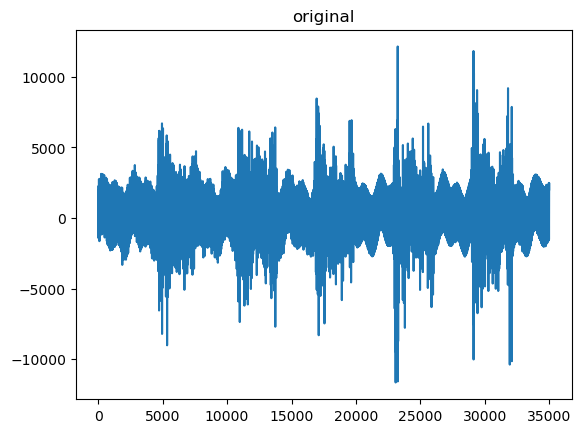

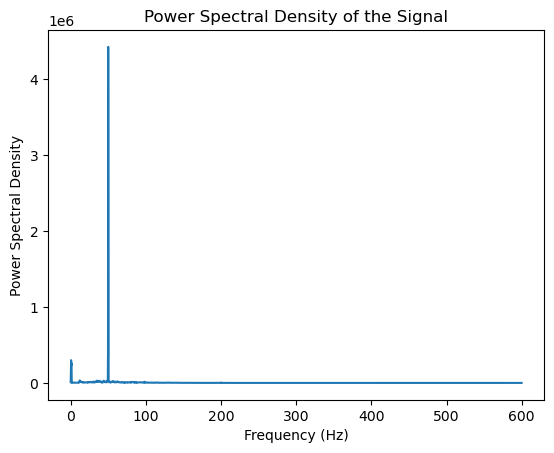

(array([0.00000000e+00, 2.74285714e-01, 5.48571429e-01, ...,
        5.99314286e+02, 5.99588571e+02, 5.99862857e+02]),
 array([9.23849812e+03, 1.43825844e+05, 2.99803301e+05, ...,
        3.60899943e+00, 9.19606886e+00, 1.16725674e+02]))

In [8]:
# 滤波器测试
data = sio.loadmat(r"E:\Data\old\original_signal.mat")['original_signal'].reshape(-1)
fs = 1200

plt.figure()
plt.plot(data)
plt.title('original')
plt.show()
show_power_spec(data, fs)

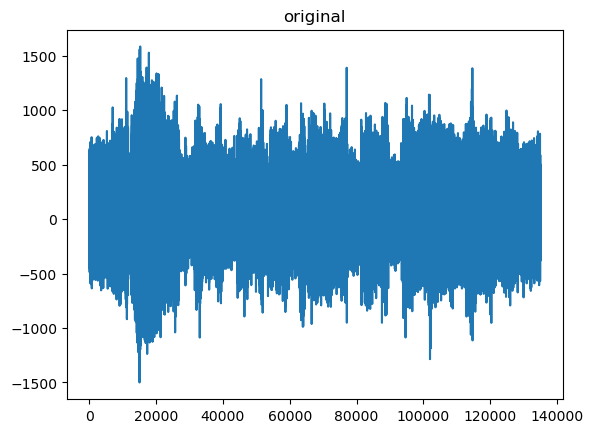

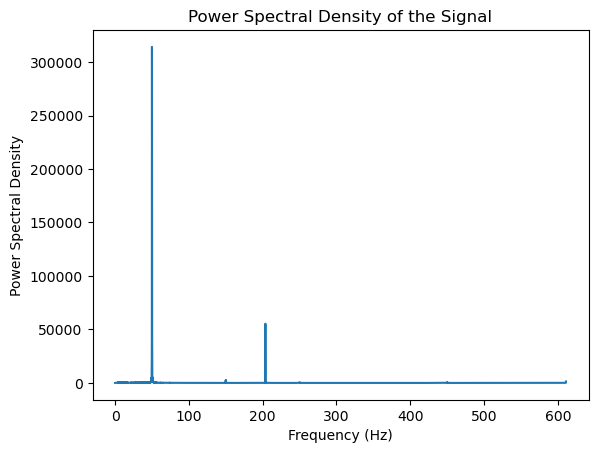

(array([0.00000000e+00, 7.24062333e-02, 1.44812467e-01, ...,
        6.10818984e+02, 6.10891391e+02, 6.10963797e+02]),
 array([1.05813594e+00, 5.28250726e+00, 8.08895359e+00, ...,
        1.86453616e+02, 4.43514363e+02, 1.31594138e+03]))

In [14]:
# 读取另外一组数据
data = sio.loadmat(r"E:\Data\积水潭患者数据集\w8s1\affected\bi_2.mat")['bi_2'][:, 10].reshape(-1)
fs = 1222


plt.figure()
plt.plot(data)
plt.title('original')
plt.show()
show_power_spec(data, fs)

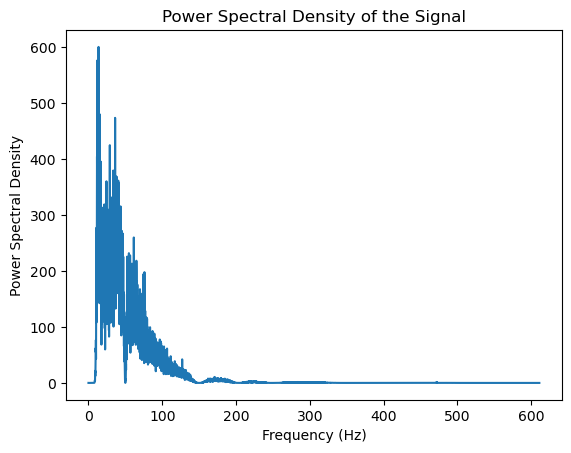

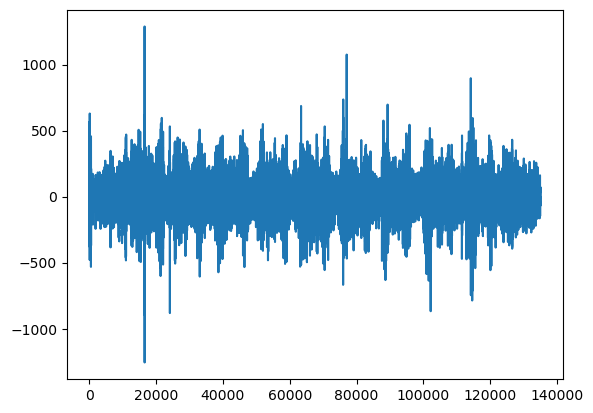

In [15]:
# 滤波方式一 噪声 50，150，203.7，250，350，407.4，450，
filter1 = NotchFilter(f0=50, fs=fs, Q=10)
filter2 = NotchFilter(f0=150, fs=fs, Q=10)
filter3 = NotchFilter(f0=203.7, fs=fs, Q=10)
filter4 = NotchFilter(f0=250, fs=fs, Q=10)
filter5 = NotchFilter(f0=350, fs=fs, Q=10)
filter6 = NotchFilter(f0=407.4, fs=fs, Q=10)
filter7 = NotchFilter(f0=450, fs=fs, Q=10)
bandpassfilter = ButterFilter(fs = fs, fc = [10, 500], order = 8, ftype='bandpass')


aa = bandpassfilter.filt(filter7.filt(filter6.filt(filter5.filt(filter4.filt(filter3.filt(filter2.filt(filter1.filt(data))))))))
# aa = bandpassfilter.filt(filter1.filt(data))

show_power_spec(aa)
plt.plot(aa)
plt.show()

In [23]:
# old original signal segment
data_segment = [aa[5000:7000],
                aa[11000:13000],
                aa[17000:18000],
                aa[23000:25000],
                aa[30000:32000]]

In [16]:
# w8s1 bi-分段
data_segment = [aa[16000:20000],
                aa[26000:30000],
                aa[40000:44000],
                aa[52000:56000],
                aa[64000:68000]]

In [24]:
for i in data_segment:
    mf, mpf = cal_freq_fea(i, fs, "psd")
    print(f"mf: {mf}, mpf: {mpf}")

mf: 48.518875870974966, mpf: 53.57540000299746
mf: 53.74892599675042, mpf: 55.979757021214496
mf: 64.00849334260263, mpf: 77.3455716877062
mf: 49.633588375002596, mpf: 64.77545259209217
mf: 50.27447388136628, mpf: 63.73532559992807


In [17]:
for i in data_segment:
    mf, mpf = cal_freq_fea(i, fs, "welch")
    print(f"mf: {mf}, mpf: {mpf}")

mf: 59.029805734921624, mpf: 63.82104014387294
mf: 47.49804058337444, mpf: 60.45780902651267
mf: 57.38804484824443, mpf: 63.30133838594481
mf: 46.54797027973667, mpf: 57.70257793146835
mf: 47.13924690174628, mpf: 57.80764252695092


unstable


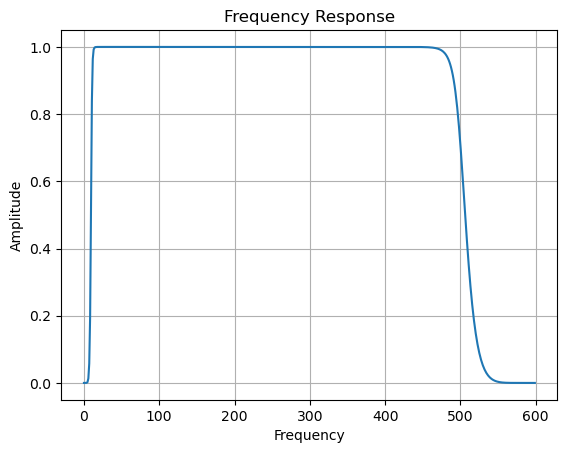

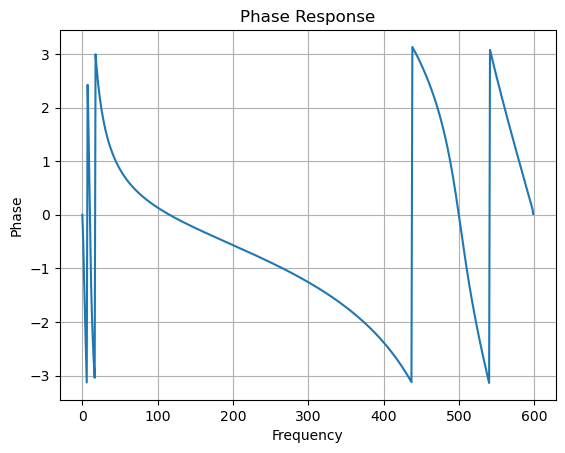

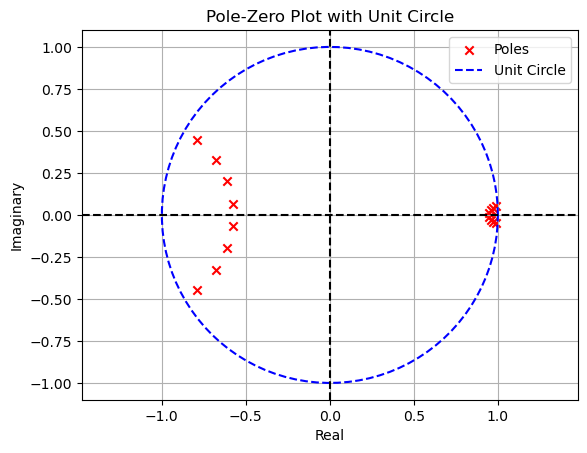

In [10]:
f1 = ButterFilter(fs = 1200, fc = [10, 500], order = 8, ftype = 'bandpass')
f1.show_character()

In [8]:
age = [73, 68, 61, 68, 64, 68, 69, 68, 71, 80, 66]
height = [163, 166, 157, 175, 170, 145, 175, 164, 160, 158, 150]
weight = [77.5, 67, 65, 72, 60, 50, 85, 60, 70, 53, 60]
bmi_index = []

print(f"年龄平均值±标准差：{np.mean(age)} ± {np.std(age)}")
print(f"身高平均值±标准差：{np.mean(height)} ± {np.std(height)}")
print(f"体重平均值±标准差：{np.mean(weight)} ± {np.std(weight)}")

for i in range(len(height)):
    bmi_index.append(weight[i]*10000/height[i]**2)
    pass


print(f"BMI平均值±标准差：{np.mean(bmi_index)} ± {np.std(bmi_index)}")

年龄平均值±标准差：68.72727272727273 ± 4.692177418386888
身高平均值±标准差：162.0909090909091 ± 9.049907537996232
体重平均值±标准差：65.4090909090909 ± 9.8921874173929
BMI平均值±标准差：24.837327093674027 ± 2.6701782678285517


In [9]:
85/1.75**2


27.755102040816325